In [3]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
%matplotlib inline
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Flatten, Dense, Dropout
import os
import random
import PIL as Image
import numpy as np
from keras.utils import to_categorical
from keras.applications import VGG16
from keras.models import load_model, model_from_json
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import random

Using TensorFlow backend.


In [5]:
## ONLY RUN THIS IF YOU ARE IN A GOOGLE COLAB ENVIRONMENT AND NEED TO ACCESS GOOGLE DRIVE FILES (e.g. to load in npz files)
# https://colab.research.google.com/notebooks/io.ipynb
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**Load in the data, check shapes, check out a few images, etc. To be used in model training**

In [0]:
## CHANGE THIS TO YOUR DRIVE DIRECTORY WITH THE RIGHT NPZ FILES!!
os.chdir('/content/gdrive/My Drive/Colab Notebooks/SI_670_Final_Project')

In [0]:
## Input shapes for the ML models
rgb = 3
height = 224
width = 224
input_shape = (height, width, rgb)

In [0]:
X_train = np.load('X_train_224.npz')['arr_0']

In [0]:
y_train = np.load('y_train_224.npz')['arr_0']

In [74]:
print(X_train.shape)
print(y_train.shape)

(5216, 224, 224, 3)
(5216,)


Shapes look good!

In [0]:
y_train = to_categorical(y_train, num_classes=2)

In [0]:
X_val = np.load('X_val_224.npz')['arr_0']
y_val = np.load('y_val_224.npz')['arr_0']

In [0]:
y_val = to_categorical(y_val, num_classes=2)

In [0]:
X_test = np.load('X_test_224.npz')['arr_0']

In [79]:
X_test.shape

(624, 224, 224, 3)

In [0]:
y_test = to_categorical(np.load('y_test_224.npz')['arr_0'])

In [0]:
y_test_actuals = np.load('y_test_224.npz')['arr_0']

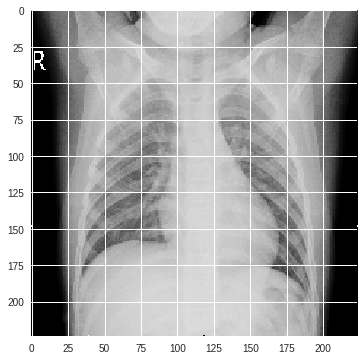

In [45]:
z = array_to_img(X_val[0])
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,6))
plt.imshow(z)

Text(0.5,1,'Pneumonia Chest X-Ray')

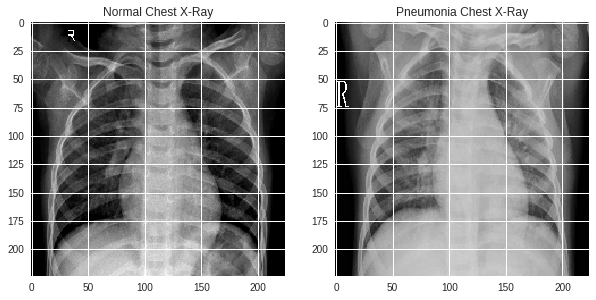

In [64]:
pneumonia_vals = random.choice(np.where(y_val == 1)[0])
normal_vals = random.choice(np.where(y_val == 0)[0])

p_img = array_to_img(X_val[pneumonia_vals])
n_img = array_to_img(X_val[normal_vals])

f = plt.figure(figsize=(10,6))
ax = f.add_subplot(1,2,1)
norm_img = plt.imshow(n_img)
ax.set_title('Normal Chest X-Ray')

ax2 = f.add_subplot(1, 2, 2)
pneu_img = plt.imshow(p_img)
ax2.set_title('Pneumonia Chest X-Ray')

## Let's functionize this --> see Display a Chest X-Ray

# Helper Functions

I wrote a bunch of these functions to do tasks such as:

*   Pre process image data into (224, 224, 3) shape
*   Load an existing model
*   Convert Keras model 2D predictions into 1D
*   Display a chest x-ray image
*   Load train, test, val files for X & y



## Helper 1: Pre Process image data


*   Slide 11 from Professor's lecture slides - 20-SI670-DeepLearning-Intro-ConvNets-Final2.pdf informed the overall approach of (a) reading in the image file, (b) decoding, (c) converting to the right array shape, and (d) scaling to [0,1] scale



In [0]:
def preprocess(path, width, height, rgb):
    '''I ran this to generate compressed npz files with the 224x224x3 tensors for each image. 
    Once these were processed, I saved them to my Google Drive account 
    to access on Google Colab notebook to run the model training. Path should be val, train, or test. 
    
    ONLY USE THESE TO PROCESS THE IMAGES -- DID NOT RUN THIS IN COLAB, ONLY ON LOCAL
    ''' 
    
    start_time = time.time()
    # Directory handling
    
    rootdir = '/Users/nikhilkalambur/Downloads/chest_xray/'
    ## CHANGE rootdir depending on where the images are.
    p = rootdir+path
    
    
    root_path, dirs, files = next(os.walk(p))
    img_files = []
    images_as_arrays = []
    y_labels = []
    for dir_ in dirs:
        if dir_ == 'NORMAL':
            print('Starting Normal', time.time() - start_time)
            img_files = [x for x in os.listdir(root_path+'/'+dir_) if x != '.DS_Store']
            # Get the files in each dir
            
            for image in img_files:
                fp = str(root_path+'/'+dir_+'/'+image)
                img = load_img(fp) # load the image
                img = img.resize((width, height)) # 224x224
                to_array = img_to_array(img)
                to_array/=255 # rescale to [0,1]
                to_array.reshape((rgb, height, width)) # 224x224x3
                images_as_arrays.append(to_array)
                y_labels.append(0)
                
        if dir_ == 'PNEUMONIA': # repeat above for PNEUMONIA
            print('Starting Pneumonia', time.time() - start_time)
            img_files = [x for x in os.listdir(root_path+'/'+dir_) if x != '.DS_Store']
            
            for image in img_files:
                fp = str(root_path+'/'+dir_+'/'+image)
                img = load_img(fp)
                img = img.resize((width, height))
                to_array = img_to_array(img)
                to_array/=255
                to_array.reshape((rgb, height, width))
                images_as_arrays.append(to_array)
                y_labels.append(1)

    images = np.array(images_as_arrays, dtype=np.float32)
    labels = np.array(y_labels)
    print(time.time() - start_time)
    print('Total Run Time:', time.time() - start_time)
    
    return images, labels
    

## Helper 2: Load an existing keras model

In [0]:
def load_existing_model(model_json, weights):
    '''https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model
     https://machinelearningmastery.com/save-load-keras-deep-learning-models/
  
    Pass in the filenames in str for the model & weights'''
  
    m = open(model_json).read()
    model = model_from_json(m)
    model.load_weights(weights)
    return model

## Helper 3: Convert the 2D output of .predict() to 1D for use in sklearn metrics

In [0]:
def get_y_preds(preds):
    '''convert model.predict() output into 1d array for sklearn metrics usage'''
    preds_adjusted = []
    for pred in preds:
    if pred[1] > pred[0]:
        preds_adjusted.append(1)
    else:
        preds_adjusted.append(0)
    return np.array(preds_adjusted)

## Helper 4: Load input data from pre processed npz files

In [0]:
def load_input_data():
    '''First line of code puts you in the right colab directory -- if you are not in colab 
      please change this to the directory with the npz file data'''
  
    os.chdir('/content/gdrive/My Drive/Colab Notebooks/SI_670_Final_Project')

    X_train = np.load('X_train_224.npz')['arr_0']
    y_train = to_categorical(np.load('y_train_224.npz')['arr_0'], num_classes=2)

    X_val = np.load('X_val_224.npz')['arr_0']
    y_val = to_categorical(np.load('y_val_224.npz')['arr_0'], num_classes=2)

    X_test = np.load('X_test_224.npz')['arr_0']
    y_test = to_categorical(np.load('y_test_224.npz')['arr_0'], num_classes=2)

    return X_train, y_train, X_val, y_val, X_test, y_test

## Helper 5: Display a Chest X-Ray

In [0]:
def display_img(y, X):
    '''Displays a Normal & Pneumonia image
    y should be the labels (0s & 1s)
    X should be the image arrays
    '''
    pneumonia_vals = random.choice(np.where(y == 1)[0])
    normal_vals = random.choice(np.where(y == 0)[0])

    p_img = array_to_img(X[pneumonia_vals])
    n_img = array_to_img(X[normal_vals])

    f = plt.figure(figsize=(10,6))
    ax = f.add_subplot(1,2,1)
    norm_img = plt.imshow(n_img)
    ax.set_title('Normal Chest X-Ray')

    ax2 = f.add_subplot(1, 2, 2)
    pneu_img = plt.imshow(p_img)
    ax2.set_title('Pneumonia Chest X-Ray')

## Helper 6: Baseline Dummy Classifier

In [0]:
def generate_dummies(test_length):
    '''Generate dummies based on selecting the most common label'''
    dummy_predictions = np.array([1 for x in range(0,test_length)])
    return dummy_predictions

## Helper 7: Load Just Test Data

In [0]:
def load_just_test_data():

    X_test = np.load('X_test_224.npz')['arr_0']
    y_test = np.load('y_test_224.npz')['arr_0']

    return X_test, y_test

## Helper 8: Get back the predicted probabilities

In [0]:
def get_y_probs(probs):
    '''convert model.predict() output into 1d array for sklearn metrics usage'''
    probs_adjusted = []
    for pred in probs:
    if pred[1] > pred[0]:
        probs_adjusted.append(pred[1])
    else:
        probs_adjusted.append(pred[0])
    return np.array(probs_adjusted)

# Let's look at some of the chest x-rays

In [0]:
X_train, y_train, X_val, y_val, X_test, y_test = load_input_data()
## Remember, these y objects are categoricalized 
## Remember, this function assumes youre in co-lab

In [0]:
y_train_for_exploring = get_y_preds(y_train)

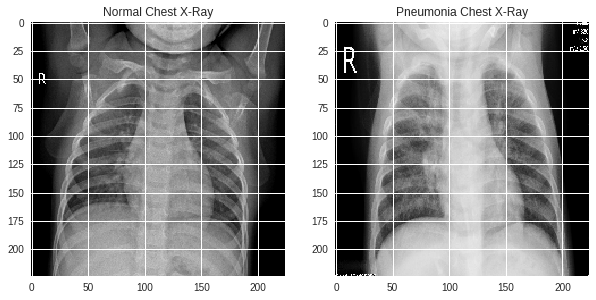

In [75]:
display_img(y_train_for_exploring, X_train)
plt.savefig("x_ray2.png")

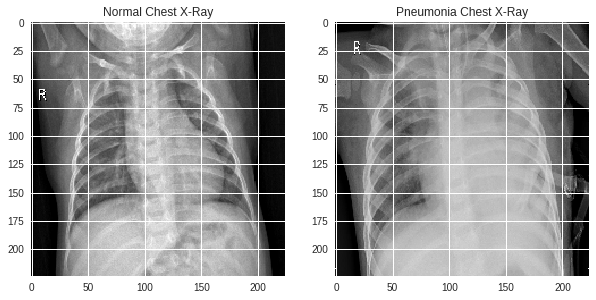

In [76]:
display_img(y_train_for_exploring, X_train)
plt.savefig("x_ray3.png")

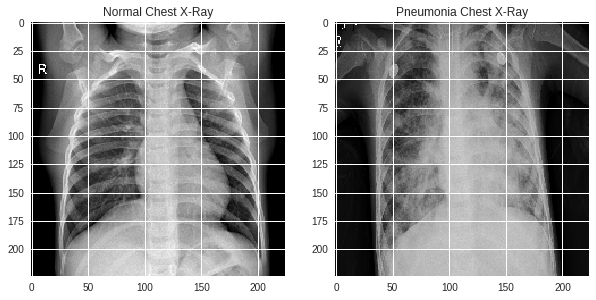

In [71]:
display_img(y_train_for_exploring, X_train)

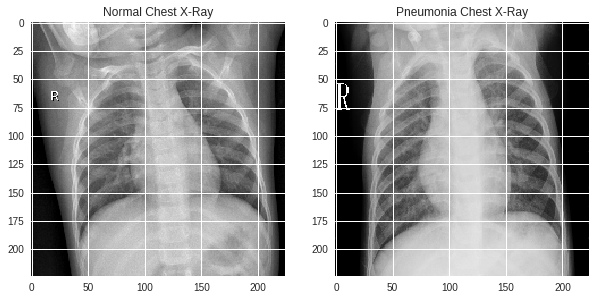

In [74]:
display_img(y_train_for_exploring, X_train)
plt.savefig("x_rays1.png")

# Let's start modelling. 

* The first batch of code basically establishes the simple non ML baseline. I ran a directory listing of the training set to get counts of the Normal vs Pneumonia images. Pneumonia was most common, so it writes a function to replicate this. 
* The second batch runs a Logistic Regression simple ML baseline by using the flattened input and 1 dense layer. The model is then saved
* This third batch of code brings in the pretrained VGG16, adds in my custom dense layers, freezes the pre-trained layers. It then fits the data to X_train. Finally, it saves the model. 
* The fourth batch repeats this, but unfreezes the top layer of VGG16, trains, then saves. 
* In the subsequent section, I plot out confusion matrices & ROC curves for these models. Then look at some layer activations






## (1) Baseline -- Dummy Classifier

* Pick the most frequent class -- Pneumonia


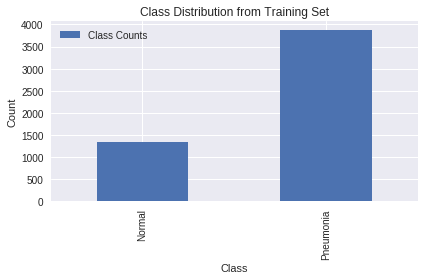

In [9]:
class_counts = pd.DataFrame(data=[1342, 3876], index=['Normal', 'Pneumonia'], columns=['Class Counts'])
# Values taken from file counts in the training subdirectories (1 folder per class)
# The raw files were on my local computer and I ran os.listdir('/TRAIN/') to get these counts. 
fig = plt.figure(figsize=(10,6))
ax = class_counts.plot(kind='bar', title='Class Distribution from Training Set')
ax.set_xlabel("Class")
ax.set_ylabel("Count")
plt.tight_layout()
plt.savefig("Class_Distribution.png")

In [0]:
def generate_dummies(test_length):
  '''Generate dummies based on selecting the most common label'''
    dummy_predictions = np.array([1 for x in range(0,test_length)])
    return dummy_predictions

## (2) Basic ML approach -- Logistic Regression


*   Simple ML approach inspired by Deep Learning with Python by F. Chollet -- 6.3.4. A basic machine-learning approach. 
*   Modified for input shape, dropout, & sigmoid activation in last dense layer (ref: https://gist.github.com/fchollet/b7507f373a3446097f26840330c1c378)



In [0]:
X_train, y_train, X_val, y_val, X_test, y_test = load_input_data()

In [56]:
lr = Sequential()
lr.add(Flatten(input_shape=input_shape)) # Flatten the 224x224x3 -> 150528 features input shape for use in Logistic
lr.add(Dense(2, activation='sigmoid')) # 1 Dense layer == Logistic Regression
lr.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_11 (Flatten)         (None, 150528)            0         
_________________________________________________________________
dense_17 (Dense)             (None, 2)                 301058    
Total params: 301,058
Trainable params: 301,058
Non-trainable params: 0
_________________________________________________________________


In [0]:
lr.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [58]:
lr.fit(X_train, y_train, batch_size=16, epochs=10, validation_data=(X_val, y_val), verbose=1)

Train on 5216 samples, validate on 16 samples
Epoch 1/10
5216/5216 [==============================] - 5s 878us/step - loss: 4.1110 - acc: 0.7423 - val_loss: 8.0151 - val_acc: 0.5000
Epoch 2/10
5216/5216 [==============================] - 4s 846us/step - loss: 4.1213 - acc: 0.7429 - val_loss: 8.0151 - val_acc: 0.5000
Epoch 3/10
5216/5216 [==============================] - 4s 843us/step - loss: 4.1213 - acc: 0.7429 - val_loss: 8.0151 - val_acc: 0.5000
Epoch 4/10
5216/5216 [==============================] - 4s 861us/step - loss: 4.1213 - acc: 0.7429 - val_loss: 8.0151 - val_acc: 0.5000
Epoch 5/10
5216/5216 [==============================] - 5s 870us/step - loss: 4.1213 - acc: 0.7429 - val_loss: 8.0151 - val_acc: 0.5000
Epoch 6/10
5216/5216 [==============================] - 5s 872us/step - loss: 4.1213 - acc: 0.7429 - val_loss: 8.0151 - val_acc: 0.5000
Epoch 7/10
5216/5216 [==============================] - 4s 841us/step - loss: 4.1213 - acc: 0.7429 - val_loss: 8.0151 - val_acc: 0.5000
Ep

In [0]:
## https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model

# Save model
model3_json = lr.to_json()
with open("lr.json", "w") as json_file:
    json_file.write(model3_json)

# Save weights
basic_cnn.save_weights("lr.h5")

## (3) Transfer Learning using frozen VGG16 & pre trained imagenet weights

In [37]:
vgg16 = VGG16(weights='imagenet'
             , include_top=False
             , input_shape=input_shape)
vgg16.summary()

58892288/58889256 [==============================] - 6s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool

In [38]:
model = Sequential()
model.add(vgg16)
vgg16.trainable = False
model.add(Dropout(.3))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(.3))
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
dropout_12 (Dropout)         (None, 7, 7, 512)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 256)               6422784   
_________________________________________________________________
dropout_13 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_14 (Dropout)         (None, 128)               0         
__________

In [0]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [40]:
model.fit(X_train, y_train, batch_size=16, epochs=10, validation_data=(X_val, y_val), verbose=1)

Train on 5216 samples, validate on 16 samples
Epoch 1/10
5216/5216 [==============================] - 58s 11ms/step - loss: 0.1853 - acc: 0.9292 - val_loss: 0.8197 - val_acc: 0.6875
Epoch 2/10
5216/5216 [==============================] - 53s 10ms/step - loss: 0.0859 - acc: 0.9701 - val_loss: 1.1057 - val_acc: 0.6875
Epoch 3/10
5216/5216 [==============================] - 53s 10ms/step - loss: 0.0776 - acc: 0.9721 - val_loss: 0.3210 - val_acc: 0.8750
Epoch 4/10
5216/5216 [==============================] - 53s 10ms/step - loss: 0.0645 - acc: 0.9771 - val_loss: 0.3255 - val_acc: 0.8750
Epoch 5/10
5216/5216 [==============================] - 53s 10ms/step - loss: 0.0640 - acc: 0.9767 - val_loss: 1.9982 - val_acc: 0.5312
Epoch 6/10
5216/5216 [==============================] - 53s 10ms/step - loss: 0.0525 - acc: 0.9816 - val_loss: 0.6627 - val_acc: 0.8125
Epoch 7/10
5216/5216 [==============================] - 53s 10ms/step - loss: 0.0375 - acc: 0.9858 - val_loss: 0.2596 - val_acc: 0.8750
Ep

In [0]:
## https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model

from keras.models import model_from_json

# Save model
model_json = model.to_json()
with open("model_vgg16_transferlearning.json", "w") as json_file:
    json_file.write(model_json)

# Save weights
model.save_weights("model_vgg16_transferlearning.h5")

## (4) Transfer Learning, but with unfrozen layers


*   https://keras.io/getting-started/faq/#how-can-i-freeze-keras-layers



In [0]:
vgg16_2 = VGG16(weights='imagenet'
             , include_top=False
             , input_shape=input_shape)

**Freeze everything but the 5th block**

In [63]:
model2 = Sequential()
model2.add(vgg16_2)
model2.add(Dropout(.3))
model2.add(Flatten())
model2.add(Dense(256, activation='relu'))
model2.add(Dropout(.3))
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(.3))
model2.add(Dense(128, activation='relu'))
model2.add(Dense(2, activation='sigmoid'))

## unfreeze certain layers..
## https://keras.io/getting-started/faq/#how-can-i-freeze-keras-layers
vgg16_2.trainable = True
for layer in vgg16_2.layers:
    if layer.name in ["block5_conv1", "block5_conv2", "block5_conv3", "block5_pool"]:
        layer.trainable = True
    else:
        layer.trainable = False
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
dropout_4 (Dropout)          (None, 7, 7, 512)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
__________

In [64]:
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model2.fit(X_train, y_train, batch_size=16, epochs=10, validation_data=(X_val, y_val), verbose=1)

Train on 5216 samples, validate on 16 samples
Epoch 1/10
5216/5216 [==============================] - 72s 14ms/step - loss: 0.3064 - acc: 0.8807 - val_loss: 0.1446 - val_acc: 0.9688
Epoch 2/10
5216/5216 [==============================] - 66s 13ms/step - loss: 0.1312 - acc: 0.9575 - val_loss: 0.2121 - val_acc: 0.9375
Epoch 3/10
5216/5216 [==============================] - 66s 13ms/step - loss: 0.1086 - acc: 0.9694 - val_loss: 0.1292 - val_acc: 0.9375
Epoch 4/10
5216/5216 [==============================] - 66s 13ms/step - loss: 0.0993 - acc: 0.9765 - val_loss: 0.0467 - val_acc: 1.0000
Epoch 5/10
5216/5216 [==============================] - 66s 13ms/step - loss: 0.0482 - acc: 0.9844 - val_loss: 0.0391 - val_acc: 1.0000
Epoch 6/10
5216/5216 [==============================] - 66s 13ms/step - loss: 0.0545 - acc: 0.9814 - val_loss: 0.1058 - val_acc: 0.9375
Epoch 7/10
5216/5216 [==============================] - 66s 13ms/step - loss: 0.0455 - acc: 0.9848 - val_loss: 0.2080 - val_acc: 0.9375
Ep

In [0]:
## https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model

# Save model
model2_json = model2.to_json()
with open("model2_vgg16_transferlearning_unfrozen_layers.json", "w") as json_file:
    json_file.write(model2_json)

# Save weights
model2.save_weights("model2_vgg16_transferlearning_unfrozen_layers.h5")

# Evaluation & Analysis

Will start by loading all of the models, creating prediction arrays, then utilizing sklearn for: 

*   Confusion Matrices
*   F1 Scores
*   ROC / AUC Curves



In [0]:
from sklearn.metrics import f1_score
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html

from sklearn.metrics import confusion_matrix
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

from sklearn.metrics import roc_curve
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html

**Reload the models & test data**

In [0]:
lr_model = load_existing_model('lr.json', 'lr.h5')

In [0]:
transfer_learning = load_existing_model('model_vgg16_transferlearning.json', 'model_vgg16_transferlearning.h5')

In [0]:
transfer_learning_unfrozen = load_existing_model('model2_vgg16_transferlearning_unfrozen_layers.json', 'model2_vgg16_transferlearning_unfrozen_layers.h5')

In [0]:
X_test, y_test = load_just_test_data()

In [0]:
y_test = get_y_preds(y_test)

**Make the predictions for each model**

In [0]:
lr_preds = lr_model.predict(X_test)

In [0]:
transfer_learning_predictions = transfer_learning.predict(X_test)

In [0]:
transfer_learning_unfrozen_predictions = transfer_learning_unfrozen.predict(X_test)

In [0]:
lr_preds = get_y_preds(lr_preds)

In [0]:
transfer_learning_predictions = get_y_preds(transfer_learning_predictions)

In [0]:
transfer_learning_unfrozen_predictions = get_y_preds(transfer_learning_unfrozen_predictions)

In [0]:
baseline_predictions = generate_dummies(y_test.shape[0])

## F1 Score Analysis

In [0]:
f1_transfer_learning = f1_score(y_test, transfer_learning_predictions)
f1_transfer_learning_unfrozen = f1_score(y_test, transfer_learning_unfrozen_predictions)
f1_baseline = f1_score(y_test, baseline_predictions)
f1_lr = f1_score(y_test, lr_preds)

[0.8641425389755011, 0.8555678059536936, 0.7692307692307693, 0.7692307692307693]


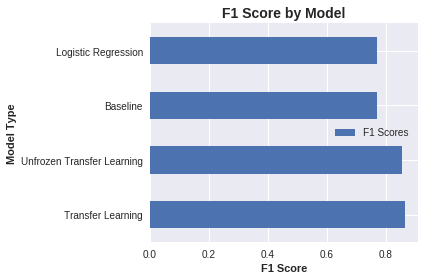

In [164]:
d = [f1_transfer_learning, f1_transfer_learning_unfrozen, f1_baseline, f1_lr]
print(d)
f1_df = pd.DataFrame(data=d
                     , index=['Transfer Learning', 'Unfrozen Transfer Learning', 'Baseline', 'Logistic Regression']
                     , columns=['F1 Scores'])
fig = plt.figure(figsize=(10,9))
ax = f1_df.plot(kind='barh')
ax.set_title("F1 Score by Model", fontsize=14, fontweight='bold')
ax.set_xlabel("F1 Score", fontweight='bold')
ax.set_ylabel("Model Type", fontweight='bold')
plt.tight_layout()
plt.savefig("F1_Score_by_Model.png")

**Takeaway: Logistic Regression model learned the same as the baseline classifier -- always predicted Pneumonia**

## Confusion Matrices



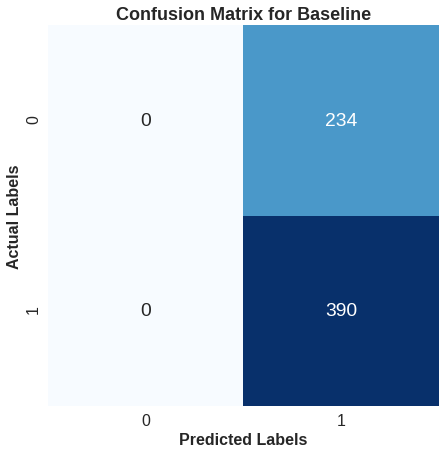

In [184]:
fig = plt.figure(figsize=(7,7))

baseline_cm = confusion_matrix(y_test, baseline_predictions)
tn, fp, fn, tp = baseline_cm.ravel()
sns.set(font_scale=1)
ax1 = sns.heatmap(baseline_cm, annot=True, fmt="d", cbar=False, cmap="Blues")
ax1.set_title("Confusion Matrix for Baseline", fontweight='bold', fontsize=18)
ax1.set_xlabel("Predicted Labels", fontweight='bold', fontsize=16)
ax1.set_ylabel("Actual Labels", fontweight='bold', fontsize=16)
plt.savefig("Confusion_Matrix_Baseline.png")

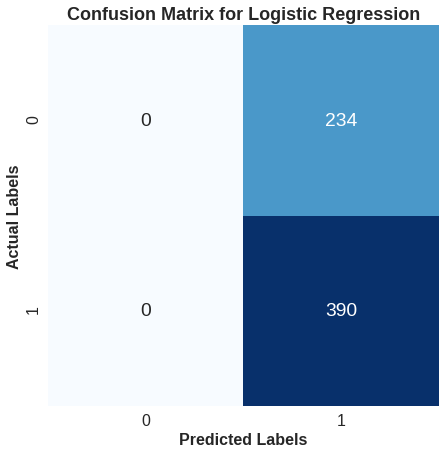

In [185]:
fig = plt.figure(figsize=(7,7))
lr_cm = confusion_matrix(y_test, lr_preds)
tn, fp, fn, tp = lr_cm.ravel()
ax1 = sns.heatmap(lr_cm, annot=True, fmt="d", cbar=False, cmap="Blues")
ax1.set_title("Confusion Matrix for Logistic Regression", fontweight='bold', fontsize=18)
ax1.set_xlabel("Predicted Labels", fontweight='bold', fontsize=16)
ax1.set_ylabel("Actual Labels", fontweight='bold', fontsize=16)
plt.savefig("Confusion_Matrix_LogisticRegression.png")

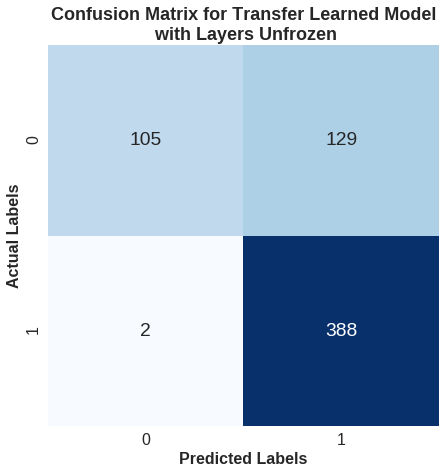

In [186]:
fig = plt.figure(figsize=(7,7))
unfrozen_cm = confusion_matrix(y_test, transfer_learning_unfrozen_predictions)
tn, fp, fn, tp = unfrozen_cm.ravel()
ax1 = sns.heatmap(unfrozen_cm, annot=True, fmt="d", cbar=False, cmap="Blues")
ax1.set_title("Confusion Matrix for Transfer Learned Model\n with Layers Unfrozen", fontweight='bold', fontsize=18)
ax1.set_xlabel("Predicted Labels", fontweight='bold', fontsize=16)
ax1.set_ylabel("Actual Labels", fontweight='bold', fontsize=16)
plt.savefig("Confusion_Matrix_TL_Unfrozen_Layers.png")

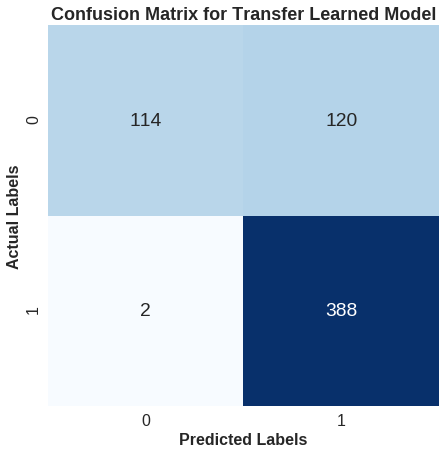

In [187]:
fig = plt.figure(figsize=(7,7))
tl_cm = confusion_matrix(y_test, transfer_learning_predictions)
tn, fp, fn, tp = tl_cm.ravel()
ax1 = sns.heatmap(tl_cm, annot=True, fmt="d", cbar=False, cmap="Blues")
ax1.set_title("Confusion Matrix for Transfer Learned Model", fontweight='bold', fontsize=18)
ax1.set_xlabel("Predicted Labels", fontweight='bold', fontsize=16)
ax1.set_ylabel("Actual Labels", fontweight='bold', fontsize=16)
plt.savefig("Confusion_Matrix_TL.png")

## ROC / AUC Curve
I learned from examples on using ROC / AUC methods from sklearn at the below documentation links:
* https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve


In [0]:
from sklearn.metrics import roc_curve, auc
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

In [0]:
lr_pp = lr_model.predict_proba(X_test)
tl_pp = transfer_learning.predict_proba(X_test)
tlu_pp = transfer_learning_unfrozen.predict_proba(X_test)

In [0]:
lr_pp = get_y_probs(lr_pp)
tl_pp = get_y_probs(tl_pp)
tlu_pp = get_y_probs(tlu_pp)

In [0]:
tl_fpr, tl_tpr, tl_thresholds = roc_curve(y_test, tl_pp)
tl_auc = auc(tl_fpr, tl_tpr)

In [0]:
tlu_fpr, tlu_tpr, tlu_thresholds = roc_curve(y_test, tlu_pp)
tlu_auc = auc(tlu_fpr, tlu_tpr)

In [0]:
lr_fpr, lr_tpr, lr_thresholds = roc_curve(y_test, lr_pp)
lr_auc = auc(lr_fpr, lr_tpr)

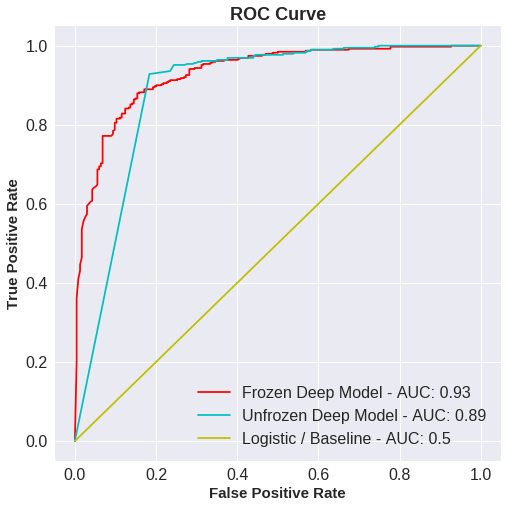

In [188]:
## Modified the code from documentation: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

fig = plt.figure(figsize=(8,8))
plt.plot(tl_fpr, tl_tpr, label="Frozen Deep Model - AUC: "+str(round(tl_auc, 2)), c='r')
plt.plot(tlu_fpr, tlu_tpr, label="Unfrozen Deep Model - AUC: "+str(round(tlu_auc, 2)), c='c')
plt.plot(lr_fpr, lr_tpr, label="Logistic / Baseline - AUC: "+str(round(lr_auc, 2)), c='y')
plt.legend(loc=4) #https://matplotlib.org/api/_as_gen/matplotlib.pyplot.legend.html
plt.title("ROC Curve", fontweight='bold', fontsize=18)
plt.xlabel("False Positive Rate", fontweight="bold", fontsize=15)
plt.ylabel("True Positive Rate", fontweight="bold", fontsize=15)
plt.savefig("ROC_Curve.png")

# Layer Activations

*   **Code modified / based on F. Chollet Deep Learning in Python Chapter 5.4**
*   Modified the code to show side by side activations for the first layer compared to a Pneumonia scan


In [0]:
from keras import models

layer_outputs = [layer.get_output_at(-1) for layer in transfer_learning.layers[:3]]
activation_model = models.Model(inputs=transfer_learning.input, outputs=layer_outputs)

In [0]:
activations = activation_model.predict(X_val) # validation set

In [122]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(16, 7, 7, 512)


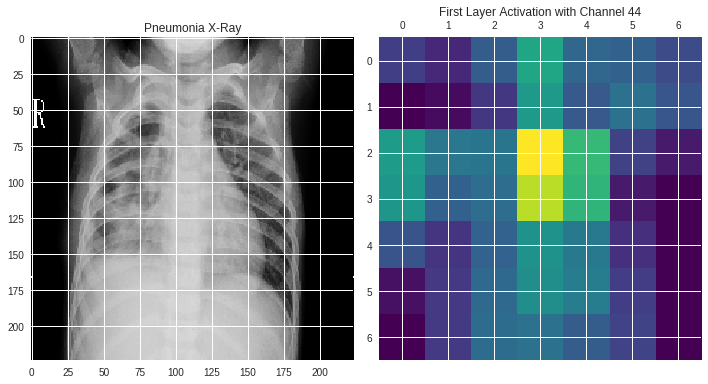

In [205]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,10))
z = array_to_img(X_val[15])
ax1.imshow(z)
ax1.set_title("Pneumonia X-Ray", fontdict={'fontsize':12})
ax2.matshow(first_layer_activation[15, :, :, 44], cmap='viridis', )
ax2.set_title("First Layer Activation with Channel 44", fontdict={'fontsize':12})
plt.tight_layout()
plt.savefig("Pneumonia X Ray Compared to Layer Activation -- 44")

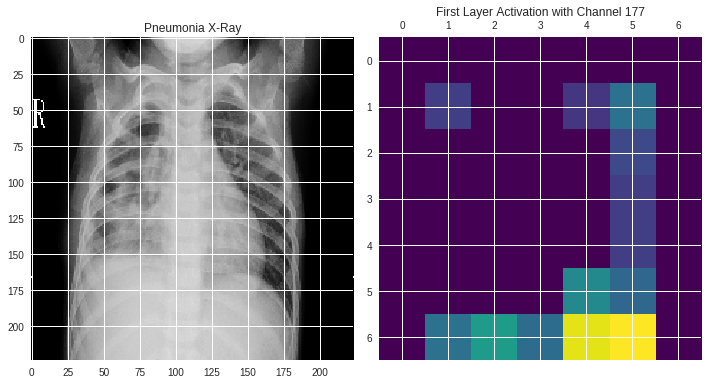

In [208]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,10))
z = array_to_img(X_val[15])
ax1.imshow(z)
ax1.set_title("Pneumonia X-Ray", fontdict={'fontsize':12})
ax2.matshow(first_layer_activation[15, :, :, 177], cmap='viridis', )
ax2.set_title("First Layer Activation with Channel 177", fontdict={'fontsize':12})
plt.tight_layout()
plt.savefig("Pneumonia X Ray Compared to Layer Activation -- 177")

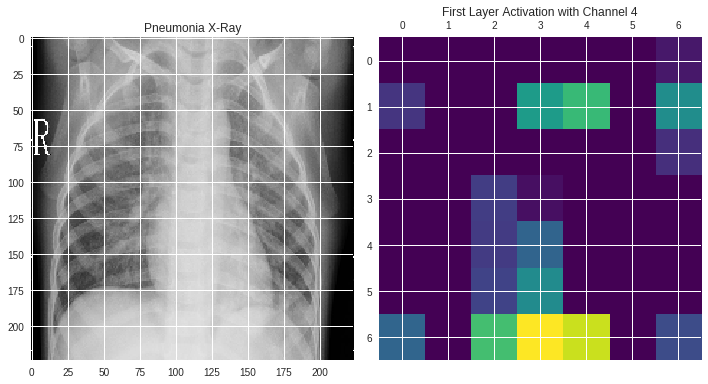

In [209]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,10))
z = array_to_img(X_val[12])
ax1.imshow(z)
ax1.set_title("Pneumonia X-Ray", fontdict={'fontsize':12})
ax2.matshow(first_layer_activation[12, :, :, 4], cmap='viridis', )
ax2.set_title("First Layer Activation with Channel 4", fontdict={'fontsize':12})
plt.tight_layout()
plt.savefig("Pneumonia X Ray Compared to Layer Activation -- 4x2.png")

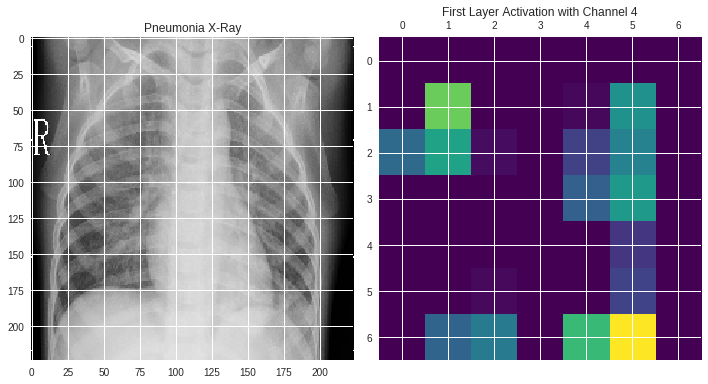

In [210]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,10))
z = array_to_img(X_val[12])
ax1.imshow(z)
ax1.set_title("Pneumonia X-Ray", fontdict={'fontsize':12})
ax2.matshow(first_layer_activation[12, :, :, 177], cmap='viridis', )
ax2.set_title("First Layer Activation with Channel 4", fontdict={'fontsize':12})
plt.tight_layout()
plt.savefig("Pneumonia X Ray Compared to Layer Activation -- 177x2.png")

In [0]:
val_preds = transfer_learning.predict(X_val)

In [0]:
val_preds = get_y_preds(val_preds)

In [191]:
val_preds

array([1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1])

In [0]:
## above proves images in layer activations above are correctly categorized as Pneumonia [12, 15]